In [1]:
import numpy as np
from Snippets import Snippets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Variational_Autoencoder_alla_Valerio import VAE

In [2]:
subfolder = "0.25_16"
model_name = "Valerio_23927"
song_orders = np.load("data_and_models\\" + subfolder + "\\" + model_name +"song_orders.npy", allow_pickle=True)

We can normalise the data and denormalise it later

In [3]:
flattened_orders = np.asarray([item for order in song_orders for item in order])
old_min = flattened_orders.min()
old_max = flattened_orders.max()

In [4]:
norm_orders = Snippets._normalise(song_orders, 0.01, 1, old_min, old_max)

In [5]:
# Add a end-token and the end of each song with value 0

song_orders = []
for song in norm_orders:
    song = np.append(song, np.zeros(song.shape[1])).reshape(song.shape[0]+1, song.shape[1])
    song_orders.append(song)

In [6]:
def generate_sequences(song_order, step: int, seq_length: int):
    X = []
    y = []
    for i in range(0, len(song_order) - seq_length, step):
        X.append(song_order[i:i+seq_length])
        y.append(song_order[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    #y = y.reshape(y.shape[0], 1, y.shape[1])
    return X,y

In [7]:
x_data = []
y_data = []

for song in song_orders:
    X_song, y_song = generate_sequences(song, step=1, seq_length=150)
    x_data.extend(X_song)
    y_data.extend(y_song)

x_data = np.array(x_data)
y_data = np.array(y_data)

print("X of one song: ", X_song.shape, "\ty of one song: ", y_song.shape)
print("X of all songs: ", x_data.shape, "\ty of all songs: ", y_data.shape)

X of one song:  (714, 150, 128) 	y of one song:  (714, 128)
X of all songs:  (20649, 150, 128) 	y of all songs:  (20649, 128)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=4)

In [9]:
from tensorflow.keras.layers import Embedding, LSTM, Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


# n_units = 256
# embedding_size = 150

# order_in = Input(shape=(x_train.shape[1], x_train.shape[2]))
# #x = Embedding(128, embedding_size,)(order_in)
# x = LSTM(n_units)(order_in)
# # x = layers.Dropout(0.2)(x)
# order_out = Dense(128, activation='softmax')(x)

# char_model = Model(order_in, order_out, name="char_rnn")

# char_model.compile(
#     # note that we use the same loss as with MNIST
#     # which is used when we want to learn a
#     # probability distribution
#     loss=MeanSquaredError,
#     optimizer=Adam(learning_rate=0.001)
# )

# char_model.summary()

model = Sequential()
model.add(LSTM((256), batch_input_shape=(None,None,128), return_sequences=True))
model.add(LSTM((128), return_sequences=False))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [10]:
history = model.fit(x_train, y_train, epochs=100, batch_size=128, shuffle=True, validation_data=(x_test,y_test))

Train on 16519 samples, validate on 4130 samples
16519/16519 [==============================] - ETA: 0s - loss: 0.0120

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


16519/16519 [==============================] - 167s 10ms/sample - loss: 0.0120 - val_loss: 0.0034


In [11]:
model.save(model_name + '_ML2_LSTM')

INFO:tensorflow:Assets written to: Valerio_23927_ML2_LSTM\assets


In [12]:
x_test.shape

(4130, 150, 128)

In [13]:
short = x_test[0][:150]
results = model.predict(short.reshape(1,short.shape[0],short.shape[1]))

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [14]:
abs(Snippets._denormalise(results[0], 0.01, 1, old_min, old_max) - Snippets._denormalise(y_test[0], 0.01, 1, old_min, old_max))

array([1.06228547e+00, 2.11895428e-01, 1.13555867e+00, 1.07471777e+00,
       4.87367885e-01, 3.69339494e-01, 2.73104616e-01, 3.04512868e-02,
       1.25589716e-01, 2.49763278e-01, 4.26413160e-01, 9.19209898e-01,
       4.27291576e-01, 4.98218604e-01, 6.48601990e-01, 2.98402597e-01,
       1.33285488e+00, 4.05556209e-01, 5.71402243e-01, 6.11651399e-02,
       1.83799809e-01, 5.92329888e-01, 6.43547830e-02, 5.10006043e-02,
       7.29911042e-01, 4.45592609e-01, 3.72063159e-01, 8.64108146e-01,
       1.62491606e+00, 9.37745313e-01, 7.21991460e-01, 9.79211967e-01,
       2.46207488e-01, 8.95361339e-01, 9.30321946e-01, 1.91549402e-01,
       2.62785572e-01, 6.92987259e-01, 1.14031900e+00, 4.57995853e-01,
       1.34041829e-01, 2.46773596e-01, 5.20223214e-01, 1.43612166e-01,
       8.94277673e-02, 6.30464521e-01, 6.42469796e-01, 1.77076391e-01,
       1.13363248e-01, 3.66729309e-01, 1.51629301e+00, 1.09325274e-01,
       5.27054486e-01, 1.00470494e+00, 3.71041614e-01, 4.04323134e-01,
      

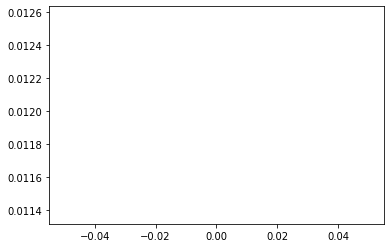

In [15]:
plt.plot(history.history['loss'])

In [16]:
def generate_order(model, seed, target_length):
    needed_coordinates = target_length - len(seed)
    seed = seed.reshape(1,seed.shape[0],seed.shape[1])
    for i in range(needed_coordinates):
        next_coordinate = model.predict(seed)
        next_coordinate = next_coordinate.reshape(1, next_coordinate.shape[0], next_coordinate.shape[1])
        seed = np.append(seed, next_coordinate, axis=1)
        print(f"reconstructed {i+1} of {needed_coordinates} coordinates", end='\r')
    output_order = seed.reshape(seed.shape[1], seed.shape[2])
    return seed

In [17]:
original = song_orders[0]
seed = original[:150]
seed.shape
reconstructed = generate_order(model, seed, len(original))


In [18]:
reconstructed = reconstructed.reshape(reconstructed.shape[1], reconstructed.shape[2])

In [19]:
original = Snippets._denormalise(original, 0.01, 1, old_min, old_max)
reconstructed = Snippets._denormalise(reconstructed, 0.01, 1, old_min, old_max)

This is the original


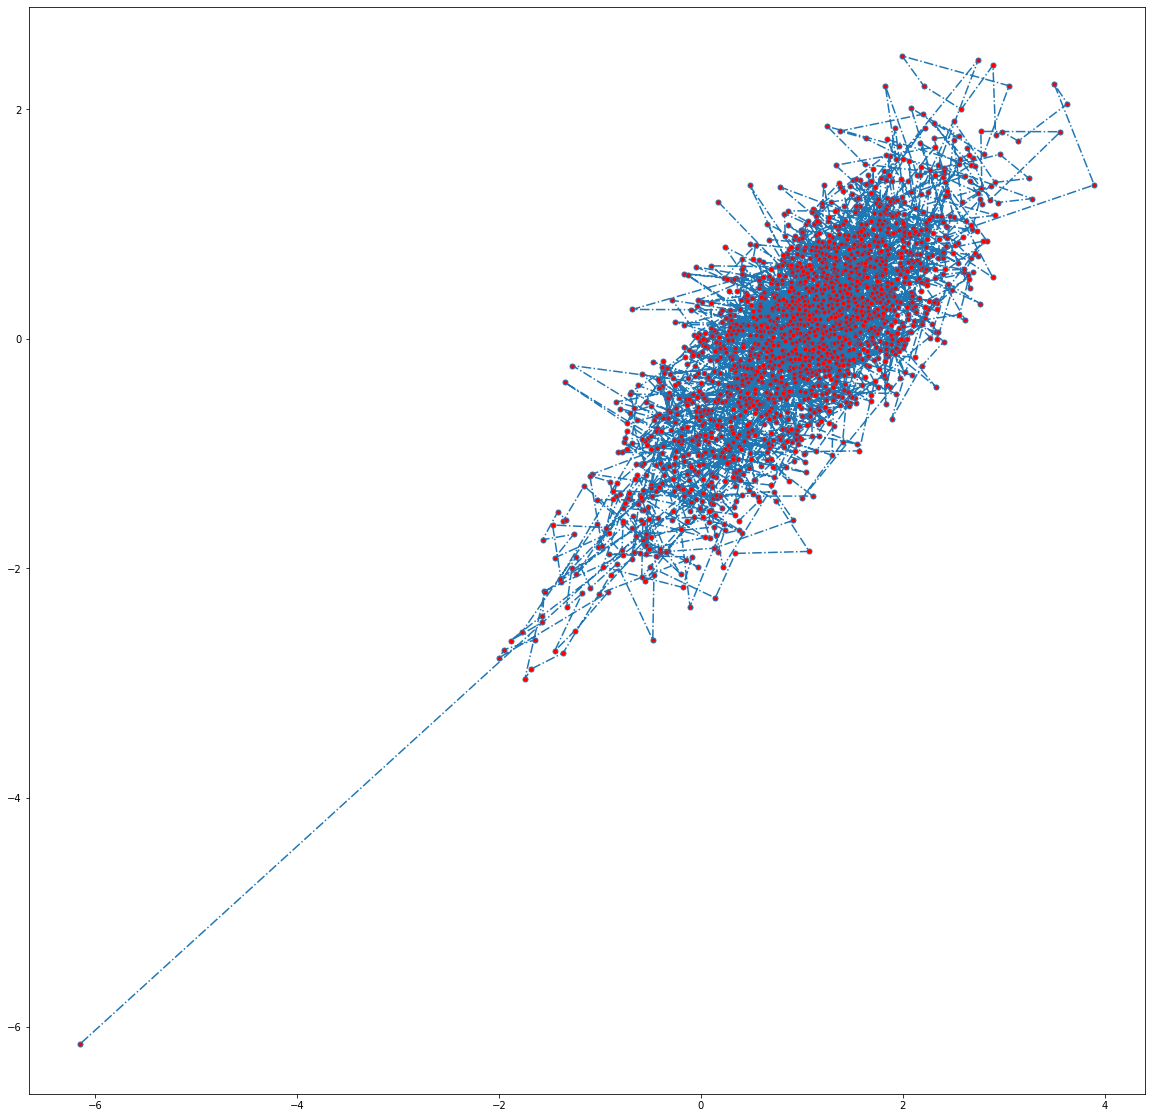

In [20]:
print("This is the original")
plt.figure(figsize=(20,20))
plt.plot(original[:, 0], original[:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()


This is the reconstruction


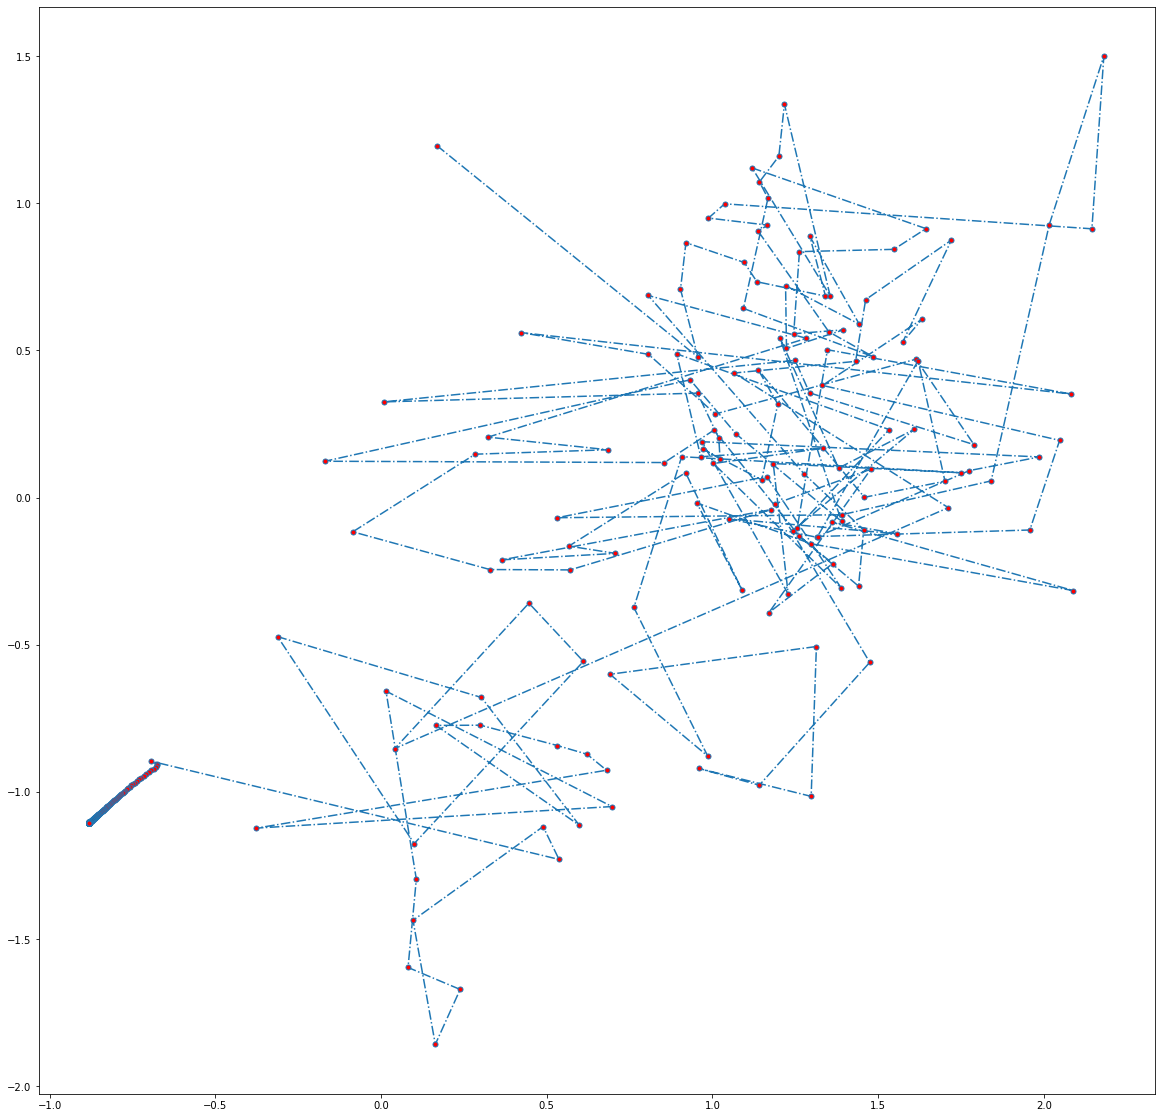

In [21]:
print("This is the reconstruction")
plt.figure(figsize=(20,20))
plt.plot(reconstructed[:, 0], reconstructed[:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

In [22]:
WIN_LENGTH = 690*2
HOP_LENGTH = 690
N_FFT = 690*2

snippet_model_name = "VAE_Vocals_128D_23927samples_20Epochs"
snippet_autoencoder = VAE.load("data_and_models\\" + subfolder +"\\" + snippet_model_name)


      
reconstructed_signal, reconstructed_spectos = Snippets.latent_representation_to_pca(latent_representations=reconstructed,
                                                                                    model=snippet_autoencoder, 
                                                                                    hop_length=HOP_LENGTH, 
                                                                                    n_fft=N_FFT, 
                                                                                    win_length=WIN_LENGTH)

Instructions for updating:
Colocations handled automatically by placer.


D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [23]:
display(Audio(reconstructed_signal, rate=44100))

NameError: name 'Audio' is not defined

In [ ]:
folder_path = 'demo_data\\stems'
paths = librosa.util.find_files(folder_path, ext=['wav'])
original_song, _ = librosa.load(paths[song_num],sr=44100, mono=True)

print("This is the original song: \n")
display(Audio(original_song, rate=44100))
